# **Data Visualization**

## Objectives

Answer Business Requirement # 1:
* Conduct a study to visually differentiate healthy cherry leaves from those with powdery mildew.

## Inputs

*  Client will input images of leaves from the following datasets : <br/>
    * inputs/cherry-leaves_dataset/cherry-leaves/train<br/>
    * inputs/cherry-leaves_dataset/cherry-leaves/validation <br/>
    * inputs/cherry-leaves_dataset/cherry-leaves/test <br/>

## Outputs

* Pickle file containing image shape embeddings
* Plot illustrating the mean and variability of images per label
* Visualization to discern the contrast between images of leaves containing fungi and uninfected leaves
* Develop code that fulfills business requirement 1 and facilitates the creation of an image montage on the Streamlit dashboard.




---

## Import Packages

In [20]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("darkgrid")
from matplotlib.image import imread

## Change working directory

In [21]:
import os
current_dir = os.getcwd()
current_dir
os.chdir('/workspace/mildew-detection-in-cherry-leaves')
print("You set a new current directory")

You set a new current directory


* Confirm the new current directory

In [22]:
current_dir = os.getcwd()
current_dir

'/workspace/mildew-detection-in-cherry-leaves'

# Set input directories 

* Set Train, Validation and Test Sets 

In [23]:
my_data_dir = 'inputs/cherry-leaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

* Set the output directory 

In [24]:
import os
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('Old Version is already available, create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old Version is already available, create a new version.


* Set label names 

In [25]:
labels = os.listdir(train_path)
print('Label for the images are',labels)

Label for the images are ['fungal-infected', 'healthy']


---

# Data Vizualization of Image Data

### Image Shape embeddings to reshape data to the desired format

* Compute average images sizes on Train Set

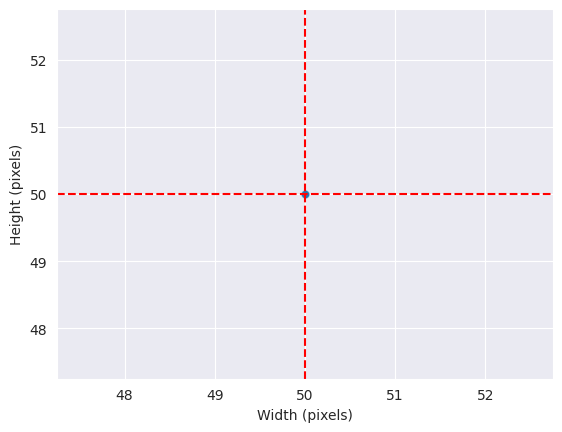

Width average: 50 
Height average: 50


In [26]:
from PIL import Image

# Define the target dimensions
target_dim = (50, 50)

dim1, dim2 = [], []
for label in labels:
  for image_filename in os.listdir(train_path + '/'+ label):
    img = Image.open(train_path + '/' + label + '/' + image_filename)
    img_resized = img.resize(target_dim, Image.LANCZOS)
    d1, d2 = img_resized.size
    dim1.append(d1)  # image height
    dim2.append(d2)  # image width


sns.set_style("darkgrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean,color='r', linestyle='--')
axes.axhline(y=dim2_mean,color='r', linestyle='--')
plt.show()
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")

* Image size for the ML model is the average from all images in 'Trainset'

In [27]:
image_shape = (dim1_mean, dim2_mean, 3)
image_shape

(50, 50, 3)

* Save image shape embeddings

In [28]:
joblib.dump(value=image_shape,
            filename=f"{file_path}/image_shape.pkl")

['outputs/v1/image_shape.pkl']

---

### Average and variability of images per label

* Here, we define a function to load images into an array (tensor) and calculate the mean and standard deviation of pixel values for both fungal-infected and non-infected leaf images.

In [29]:
from tensorflow.keras.preprocessing import image

def load_image_as_array(current_dir,new_size=(50,50), n_images_per_label = 20): #Function that loads the images and their dimension
    X, y = np.array([],dtype='int'), np.array([], dtype='object')
    labels = os.listdir(current_dir)

    for label in labels:
        counter=0
        for image_filename in os.listdir(current_dir + '/' + label):
            
            if counter < n_images_per_label:
                img = image.load_img(current_dir + '/' + label + '/' + image_filename, target_size=new_size)
                if image.img_to_array(img).max() > 1:
                    image_resized = image.img_to_array(img) /255
                else:
                    image_resized = image.img_to_array(img)
                # Images are, after getting scaled and reshaped in a X array variable , in the y variable we store the label names for each image stored in the X array
                X = np.append(X, image_resized).reshape(-1, new_size[0], new_size[1], image_resized.shape[2])
                y = np.append(y, label)
                counter += 1
    # Function returns the X and Y array variables to be used when plotting 
    return X, y  



### Load the shapes of the images and their corresponding labels into an array.

In [30]:
X, y = load_image_as_array(current_dir=train_path,
                            new_size=(50,50),
                            n_images_per_label=40)
print(X.shape, y.shape)

(80, 50, 50, 3) (80,)


### Generate a plot illustrating and save the mean and variability of images for each label.

In [31]:
# Function to plot the mean and variability of images per label

def plot_mean_variability_per_labels(X, y, figsize=(12,5), save_image=False):
  """
   The pseudo code for the function is:
  * Loop in all labels
  * Subset an array for given label
  * Calculate mean and standard deviation
  * Create a figure displaying mean and variability of images
  * Save image

  """

  for label_to_display in np.unique(y):
    sns.set_style("dark")

    y = y.reshape(-1,1,1)
    boolean_mask = np.any(y==label_to_display,axis=1).reshape(-1)
    arr = X[boolean_mask]

    avg_img = np.mean(arr, axis = 0)
    std_img = np.std(arr, axis = 0)
    print(f"~~~ Label {label_to_display} ~~~")
    print(f"Image Shape: {avg_img.shape}")
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    axes[0].set_title(f"Average Image for label {label_to_display}")
    axes[0].imshow(avg_img, cmap='Greens')
    axes[1].set_title(f"Variability image for label {label_to_display}")
    axes[1].imshow(std_img, cmap='Greens')

    if save_image:
      plt.savefig(f"{file_path}/avg_var_{label_to_display}.png", bbox_inches='tight', dpi=150)
    else:
      plt.tight_layout()
      plt.show()
      print("\n")

~~~ Label fungal-infected ~~~
Image Shape: (50, 50, 3)
~~~ Label healthy ~~~
Image Shape: (50, 50, 3)


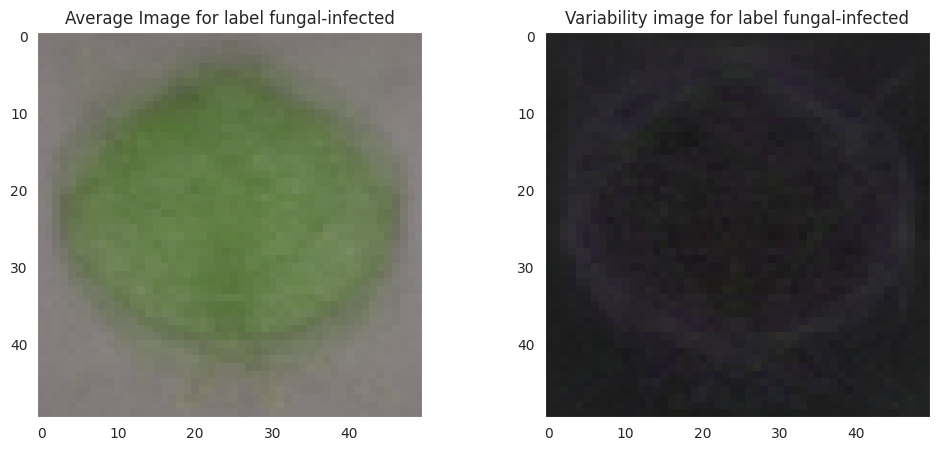

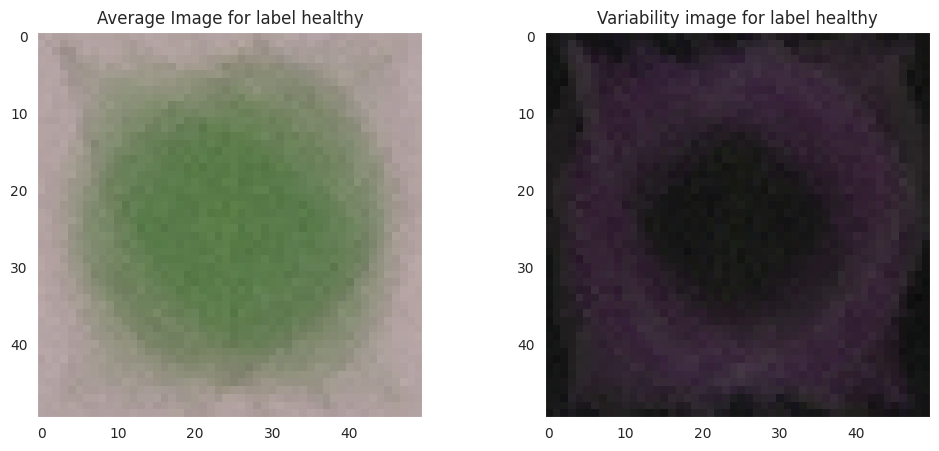

In [32]:

plot_mean_variability_per_labels(X=X, y=y, figsize=(12,5),save_image=True)

## Difference between average fungal-contained and average uninfected leaf images

* Function 'dif_bet_avg_image_labels_data_as_array' will output a figure of plots for average fungal-contained and uninfected leaf images. 

In [33]:
def subset_image_label(X,y,label_to_display):
  y = y.reshape(-1,1,1)
  boolean_mask = np.any(y==label_to_display,axis=1).reshape(-1)
  df = X[boolean_mask]
  return df


def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2, figsize=(20,5), save_image=False):
  sns.set_style("dark")

  if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
    print(f"Either label {label} or label {label_2}, are not in {np.unique(y)} ")
    return

  # calculate mean from label1
  images_label = subset_image_label(X, y, label_1)
  label1_avg = np.mean(images_label, axis = 0)

  # calculate mean from label2
  images_label = subset_image_label(X, y, label_2)
  label2_avg = np.mean(images_label, axis = 0)

  # calculate difference and plot difference, avg label1 and avg label2
  difference_mean = label1_avg - label2_avg
  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
  axes[0].imshow(label1_avg, cmap='Greens')
  axes[0].set_title(f'Average {label_1}')
  axes[1].imshow(label2_avg, cmap='Greens')
  axes[1].set_title(f'Average {label_2}')
  axes[2].imshow(difference_mean, cmap='Greens')
  axes[2].set_title(f'Difference image: Avg {label_1} & {label_2}')
  if save_image:
    plt.savefig(f"{file_path}/avg_diff.png", bbox_inches='tight', dpi=150)
  else:
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


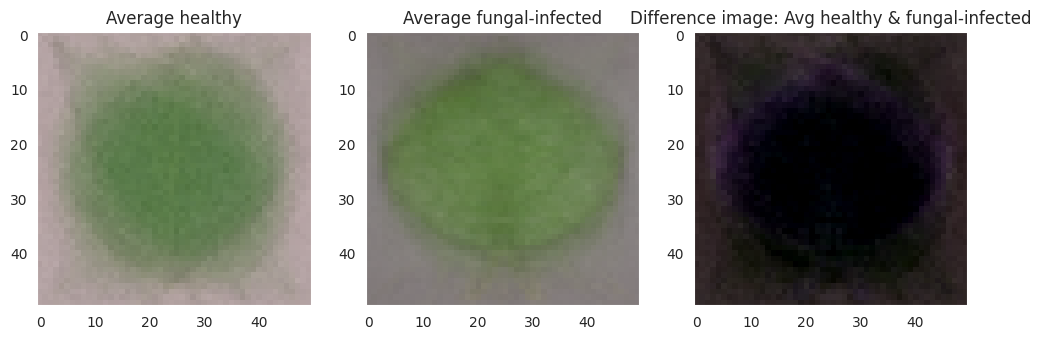

In [34]:
diff_bet_avg_image_labels_data_as_array(X=X, y=y,
                                        label_1='healthy', label_2='fungal-infected',
                                        figsize=(12,10),
                                        save_image=True
                                        )

### Image montage 

* Gallery showcasing pre-labeled images sourced from our input folder, exhibiting randomly selected images from our dataset for each label.

In [35]:
import itertools
import random
sns.set_style('dark')

def image_montage(dir_path, label_to_display, nrows, ncols, figsize=(15,10)):

    labels = os.listdir(dir_path)

    #specify the class to display
    if label_to_display in labels :
        #check if your gallery size is bigger than the subset size
        images_list = os.listdir(dir_path+ '/' + label_to_display)
        if nrows * ncols < len(images_list):
            img_idx = random.sample(images_list, nrows * ncols)
        else:
            print(f'Decrease nrows or ncols to create your montage. /n'
                  f'There are {len(images_list)} in your subset.'
                  f'You requested a montage with {nrows * ncols} spaces')
            return
        #Create a list of axes based on rows and ncols
        list_rows= range(0,nrows)
        list_cols= range(0,ncols)
        plot_idx = list(itertools.product(list_rows, list_cols))

        #Create a figure and display images
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        for x in range(0,nrows * ncols):
            img = imread(dir_path + '/' + label_to_display + '/' + img_idx[x])
            img_shape = (50,50)
            axes[plot_idx[x][0], plot_idx[x][1]].imshow(img)
            axes[plot_idx[x][0], plot_idx[x][1]].set_title(f"Width {img_shape[1]}px x Height {img_shape[0]}px")
            axes[plot_idx[x][0], plot_idx[x][1]].set_xticks([])
            axes[plot_idx[x][0], plot_idx[x][1]].set_yticks([])
        plt.tight_layout()
        plt.show()
    else:
        print("The label you selected doesn't exist.")
        print(f"The existing options are: {labels}")

* Run the montage in all labels 

fungal-infected


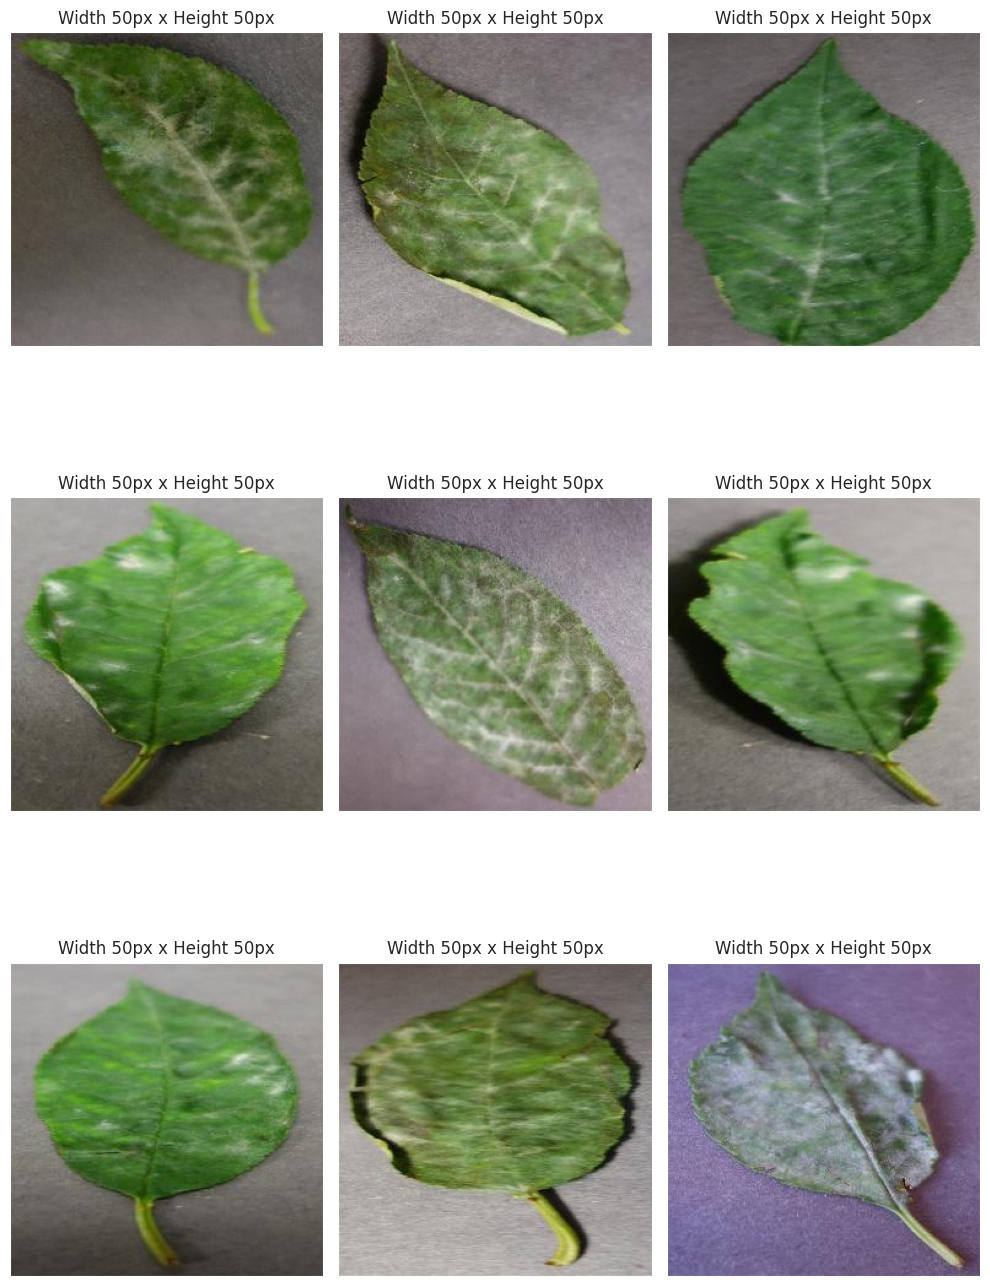



healthy


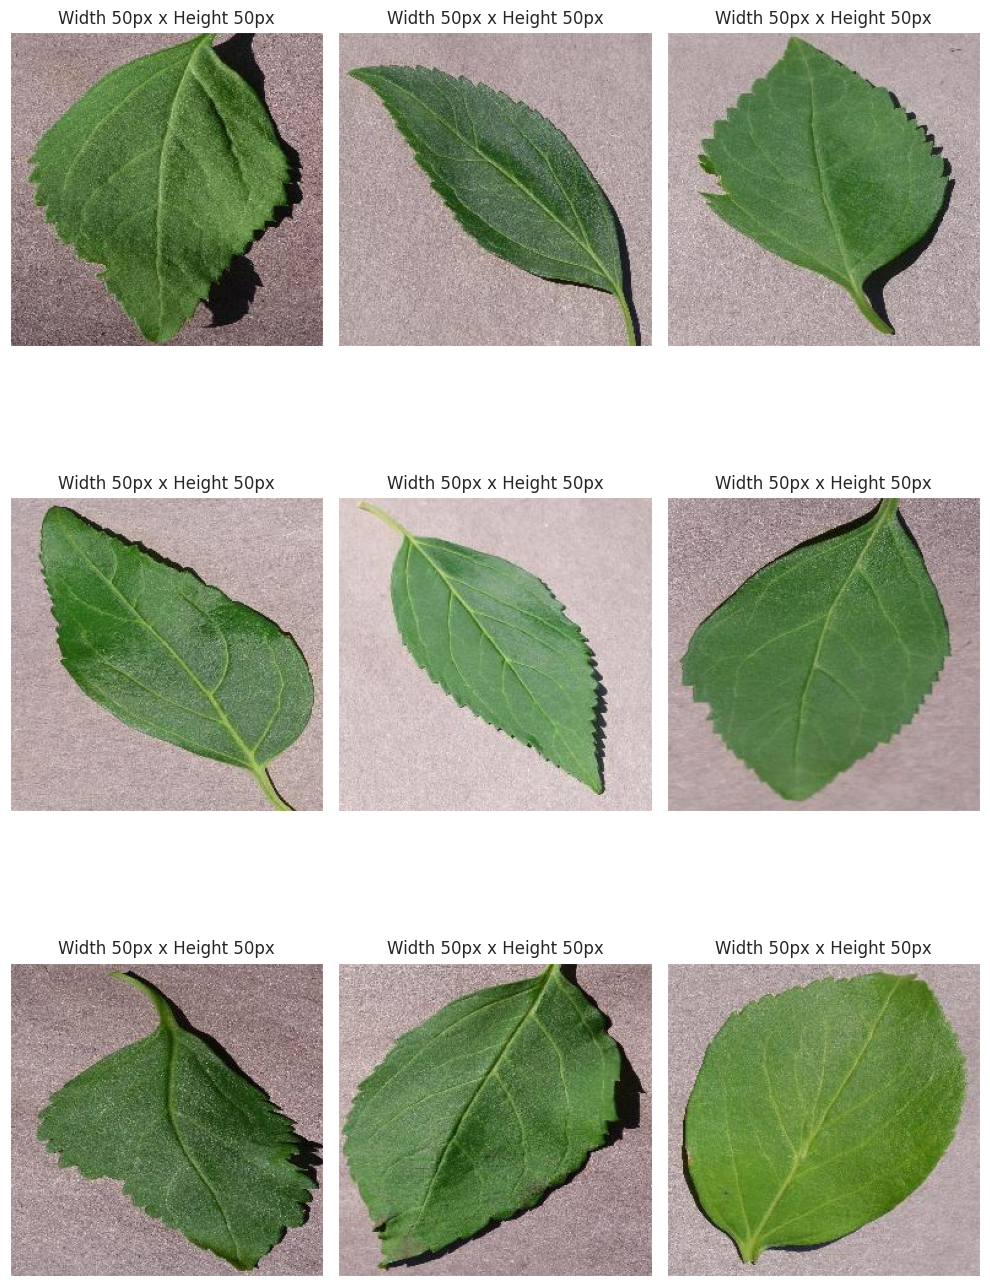

In [36]:
for label in labels:
  print(label)
  image_montage(dir_path= train_path,
                label_to_display= label,
                nrows=3, ncols=3,
                figsize=(10,15)
                )
  print("\n")

### Conclusions and Next Steps 

* In this notebook, our focus was on visually distinguishing between images from different classes. We conducted comparisons and highlighted the distinctions between healthy and fungal-infected leaves versus healthy ones, showcasing their average differences. 
* By examining the statistical disparities in the mean and variability of images across various classes, we aimed to anticipate the data quality for model training purposes.

---

# Push files to Repo

In [18]:
import os
try:
 # Change directory to your repository
    os.chdir("/workspace/mildew-detection-in-cherry-leaves/")

    # Add all files to the staging area
    os.system("git add .")

    # Commit the changes with a message
    commit_message = "Save the Data Visualization  notebook "
    os.system(f"git commit -m '{commit_message}'")

    # Push changes to the origin
    os.system("git push origin main")  
    
except Exception as e:
   print(e)


[main 1f266d7] Save the Data Visualization  notebook
 2 files changed, 76 insertions(+), 101 deletions(-)


To https://github.com/FerchaPombo/mildew-detection-in-cherry-leaves.git
   72a7704..1f266d7  main -> main
